# Causal Analysis of Synthetic Dataset

In [37]:
import networkx as nx
import numpy as np
import pandas as pd
import dowhy
import dowhy.plotter as plotter
from dowhy.do_why import CausalModel
import random
import seaborn as sns
from pymatch.Matcher import Matcher

sns.set_context("notebook")
%matplotlib inline

random.seed(0)
np.random.seed(0)

TREATMENT = 'ContinentOfBirth'
#TREATMENT = 'CitizenshipContinent'

OUTCOME_NAME = 'Last Name Correct'

TREATMENT_COL = 'T'
OUTCOME = 'O'

In [38]:
dataset = pd.read_csv('data/synthetic-dataset-scenario-B.csv')

In [39]:
# Introduce binary treatment column as proposed by Data X-Ray
dataset[TREATMENT_COL] = dataset[TREATMENT] == 'Asia'
dataset.rename({OUTCOME_NAME: OUTCOME}, axis=1, inplace=True)
dataset.head()

,Source,Last Name,CountryOfBirth,ContinentOfBirth,CitizenshipCountry,CitizenshipContinent,NumChildren,MaritalStatus,O,T
0,B,ztyji,China,Asia,China,Asia,2,Married,False,True
1,B,eqjin,Canada,North America,Canada,North America,2,Single,True,False
2,D,npqyp,China,Asia,China,Asia,4,Widowed,False,True
3,A,vwsqy,France,Europe,Canada,North America,4,Widowed,True,False
4,A,jsnjz,Japan,Asia,Japan,Asia,2,Single,True,True


## Analysis with `doWhy`

In [162]:
graph = nx.DiGraph()

# potential confounders
ignore_vars = ['Last Name', OUTCOME, TREATMENT_COL, TREATMENT, 'CountryOfBirth']
for col in dataset.drop(ignore_vars, axis=1).columns:
    graph.add_edge(col, TREATMENT_COL)
    graph.add_edge(col, OUTCOME)
    
#graph.add_edge('Unobserved Confounders', 'Treatment')
#graph.add_edge('Unobserved Confounders', 'Last Name Correct')

# Assumed causal relation
graph.add_edge(TREATMENT_COL, OUTCOME)

['CitizenshipCountry', 'MaritalStatus', 'CitizenshipContinent', 'NumChildren', 'Source']
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
Model to find the causal effect of treatment Treatment on outcome LastNameCorrect
Using Matplotlib for plotting


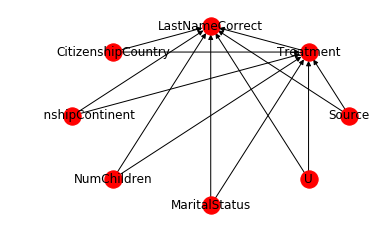

In [163]:
model = CausalModel(data = dataset, treatment=TREATMENT_COL, outcome=OUTCOME, graph=''.join(nx.generate_gml(graph)))
model.view_model()

In [164]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'CitizenshipCountry', 'MaritalStatus', 'CitizenshipContinent', 'Source', 'NumChildren', 'U'}


{'observed': 'yes'}
{'observed': 'yes'}
{'observed': 'yes'}
{'observed': 'yes'}
{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                                         
──────────(Expectation(LastNameCorrect|CitizenshipCountry,MaritalStatus,Citize
dTreatment                                                                    

                                   
nshipContinent,Source,NumChildren))
                                   
Estimand assumption 1, Unconfoundedness: If U→Treatment and U→LastNameCorrect then P(LastNameCorrect|Treatment,CitizenshipCountry,MaritalStatus,CitizenshipContinent,Source,NumChildren,U) = P(LastNameCorrect|Treatment,CitizenshipCountry,MaritalStatus,CitizenshipContinent,Source,NumChildren)
### Estimand : 2
Estimand name: iv
No such variable found!



In [165]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name='backdoor.propensity_score_stratification')
print(causal_estimate)
print('Causal Estimate is ' + str(causal_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: LastNameCorrect~Treatment+CitizenshipCountry+MaritalStatus+CitizenshipContinent+Source+NumChildren


PropensityScoreStratificationEstimator


C:\Users\Amnesix\DOCUME~1\KIT---~1\00-AUS~1\Studium\WINTER~1\CAUSAL~1\mldcpy\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                                         
──────────(Expectation(LastNameCorrect|CitizenshipCountry,MaritalStatus,Citize
dTreatment                                                                    

                                   
nshipContinent,Source,NumChildren))
                                   
Estimand assumption 1, Unconfoundedness: If U→Treatment and U→LastNameCorrect then P(LastNameCorrect|Treatment,CitizenshipCountry,MaritalStatus,CitizenshipContinent,Source,NumChildren,U) = P(LastNameCorrect|Treatment,CitizenshipCountry,MaritalStatus,CitizenshipContinent,Source,NumChildren)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: LastNameCorrect~Treatment+CitizenshipCountry+MaritalStatus+CitizenshipContinent+Source+NumChildren
## Estimate
Value: -0.1383356409548203

Causal Estimate

In [44]:
res_random = model.refute_estimate(identified_estimand, causal_estimate, method_name='random_common_cause')
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: l~t+MaritalStatus+NumChildren+CitizenshipContinent+Source+CitizenshipCountry+w_random


Refute: Add a Random Common Cause
Estimated effect:(-0.1282816229116945,)
New effect:(-0.13454653937947494,)



In [45]:
res_placebo = model.refute_estimate(identified_estimand, causal_estimate, method_name='placebo_treatment_refuter', placebo_type='permute')
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: l~placebo+MaritalStatus+NumChildren+CitizenshipContinent+Source+CitizenshipCountry


Refute: Use a Placebo Treatment
Estimated effect:(-0.1282816229116945,)
New effect:(0.015214797136038186,)



In [46]:
res_subset = model.refute_estimate(identified_estimand, causal_estimate, method_name='data_subset_refuter', subset_fraction=0.9)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: l~t+MaritalStatus+NumChildren+CitizenshipContinent+Source+CitizenshipCountry


Refute: Use a subset of data
Estimated effect:(-0.1282816229116945,)
New effect:(-0.1387876780390858,)



## Analysis with `PyMatch`

In [38]:
dataset.columns

Index(['Source', 'Last Name', 'CountryOfBirth', 'ContinentOfBirth',
       'CitizenshipCountry', 'CitizenshipContinent', 'NumChildren',
       'MaritalStatus', 'LastNameCorrect', 'Treatment'],
      dtype='object')

In [42]:
#m = Matcher(dataset[dataset[TREATMENT_COL]], dataset[~dataset[TREATMENT_COL]], yvar=TREATMENT_COL, exclude=['Last Name', 'CitizenshipCountry', 'CitizenshipContinent', OUTCOME])
m = Matcher(dataset[dataset[TREATMENT_COL]], dataset[~dataset[TREATMENT_COL]], yvar=TREATMENT_COL, exclude=['Last Name', 'CountryOfBirth', 'ContinentOfBirth', OUTCOME])

Formula:
T ~ Source+CitizenshipCountry+CitizenshipContinent+NumChildren+MaritalStatus
n majority: 6648
n minority: 3352


Fitting Models on Balanced Samples: 100\100
Average Accuracy: 92.69%


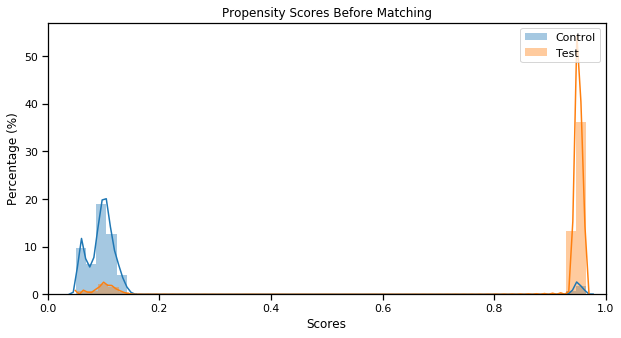

In [48]:
m.fit_scores(balance=True, nmodels=100)
m.predict_scores()
m.plot_scores()

### Propensity Score Matching

C:\Users\Amnesix\DOCUME~1\KIT---~1\00-AUS~1\Studium\WINTER~1\CAUSAL~1\mldcpy\lib\site-packages\pymatch\Matcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.matched_data['match_id'] = match_ids
C:\Users\Amnesix\DOCUME~1\KIT---~1\00-AUS~1\Studium\WINTER~1\CAUSAL~1\mldcpy\lib\site-packages\pymatch\Matcher.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.matched_data['record_id'] = self.matched_data.index


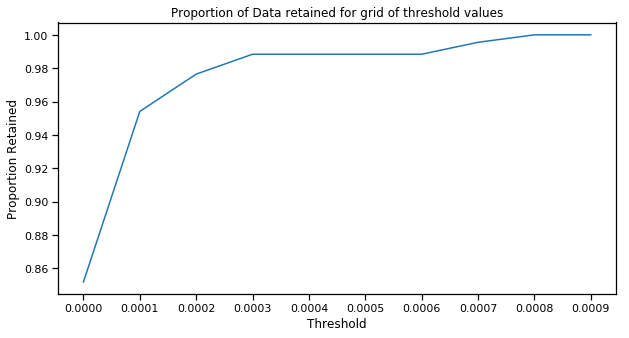

In [50]:
m.tune_threshold(method='random')

In [51]:
m.match(method="min", nmatches=1, threshold=0.0002)
m.record_frequency()

,freq,n_records
0,1,3514
1,2,50
2,3,22
3,4,2
4,6,1
5,7,1
6,9,1
7,11,2
8,12,2
9,13,4


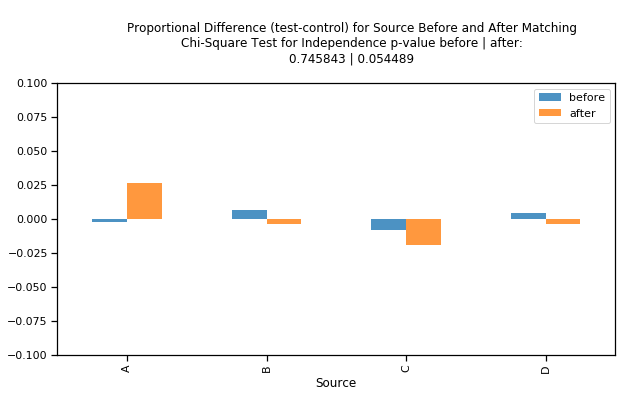

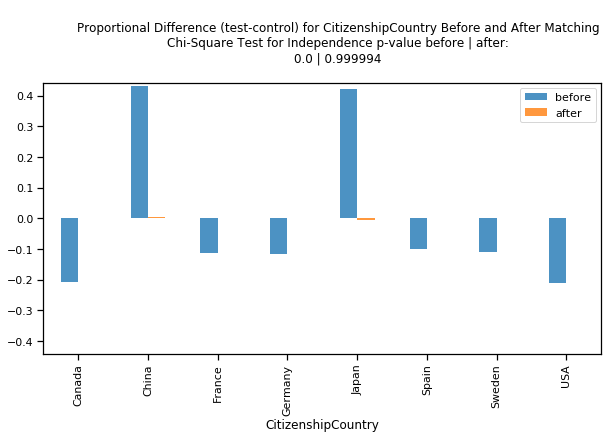

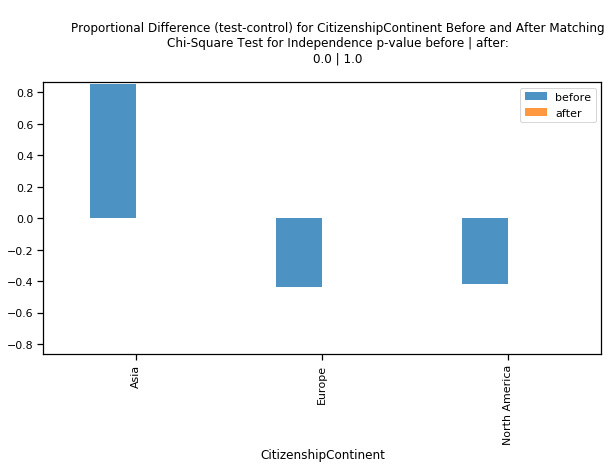

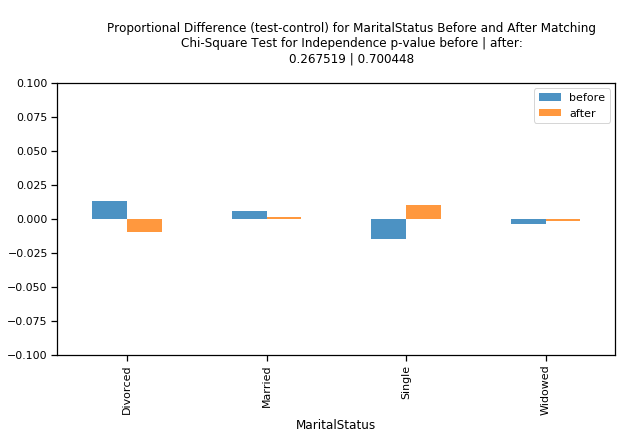

In [52]:
m.assign_weight_vector()
categorical_results = m.compare_categorical(return_table=True)

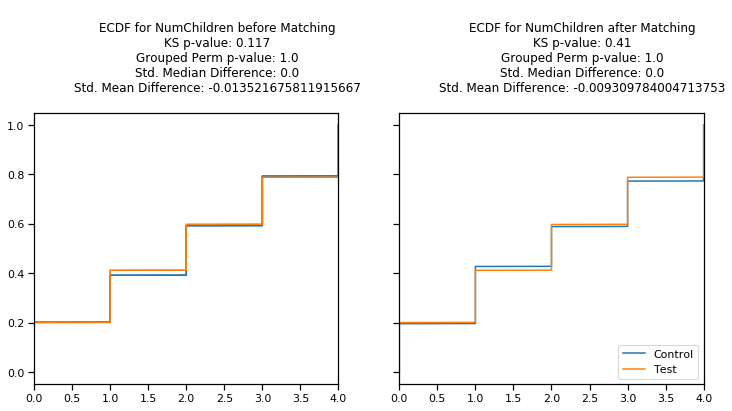

In [53]:
cc = m.compare_continuous(return_table=True)

In [54]:
# ATE through propensity score matching
matched_data = m.matched_data.copy()
treated = matched_data[matched_data[TREATMENT_COL] == 1].set_index('match_id')
control = matched_data[matched_data[TREATMENT_COL] != 1].set_index('match_id')

matched = treated.join(control, lsuffix='_treated', rsuffix='_control')
matched['treatment_effect'] = matched[OUTCOME+'_treated'].astype(int) - matched[OUTCOME+'_control'].astype(int)

ate = matched['treatment_effect'].mean()
ate

### Propensity Score Stratification

In [56]:
def propensity_stratification(scored_data, num_strata=50, min_count_per_stratum=10):
    scored_data['stratum'] = ((scored_data['scores'].rank(ascending=True) / len(scored_data)) * num_strata).round(0)

    scored_data['Tbar'] = (1 - scored_data[TREATMENT_COL])
    scored_data['T_y'] = scored_data[TREATMENT_COL] * scored_data[OUTCOME]
    scored_data['Tbar_y'] = scored_data['Tbar'] * scored_data[OUTCOME]

    stratified = scored_data.groupby('stratum').filter(lambda stratum: min(stratum.loc[stratum[TREATMENT_COL] == 1].shape[0],
                                                                           stratum.loc[stratum[TREATMENT_COL] == 0].shape[0]) > min_count_per_stratum)

    lost = list(filter(lambda x: x not in stratified['stratum'].unique(), range(num_strata)))
    if len(lost) > 0:
        print('Lost strata {} because they were too small'.format(lost))

    weighted_outcomes = stratified.groupby('stratum').agg({TREATMENT_COL: ['sum'], 'Tbar': ['sum'], 'T_y': ['sum'], 'Tbar_y': ['sum']})
    weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
    treatment_sum_name = TREATMENT_COL + "_sum"

    weighted_outcomes['T_y_mean'] = weighted_outcomes['T_y_sum'] / weighted_outcomes[treatment_sum_name]
    weighted_outcomes['Tbar_y_mean'] = weighted_outcomes['Tbar_y_sum'] / weighted_outcomes['Tbar_sum']
    weighted_outcomes['effect'] = weighted_outcomes['T_y_mean'] - weighted_outcomes['Tbar_y_mean']
    treatment_population = weighted_outcomes[treatment_sum_name].sum()

    ate = (weighted_outcomes['effect'] * weighted_outcomes[treatment_sum_name]).sum() / treatment_population
    return ate

propensity_stratification(m.matched_data.copy())

#### Get statistical significance by comparing with placebo treatment

In [57]:
n_iter = 50

placebo_results = []
placebo_treated = m.matched_data.copy()
for i in range(n_iter):
    placebo_treated[TREATMENT_COL] = np.random.randint(0, 2, len(placebo_treated))
    placebo_results.append(propensity_stratification(placebo_treated))

In [63]:
treatment_results = []
for i in range(n_iter):
    m.fit_scores(balance=True, nmodels=1) # re-fit model. Expensive.
    m.predict_scores()
    m.match(method="random", nmatches=1, threshold=0.0002) # TODO why does this change scores?
    treatment_results.append(propensity_stratification(m.matched_data.copy()))

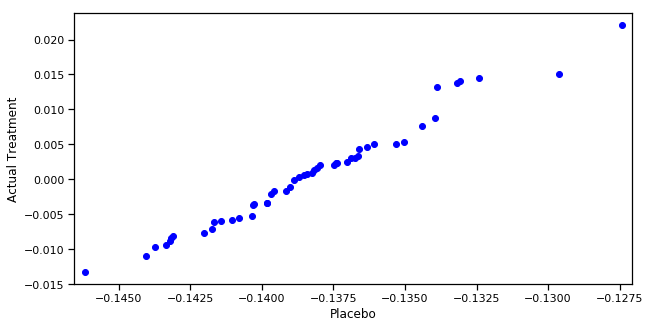

In [64]:
# QQ-Plot to compare empirical distributions. If straight line, no significant difference from placebo treatment.
from statsmodels.graphics.gofplots import qqplot_2samples
import pylab

qqplot_2samples(np.array(placebo_results), np.array(treatment_results), xlabel='Placebo', ylabel='Actual Treatment')
pylab.show()